In [2]:
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

%matplotlib inline

Welcome to JupyROOT 6.12/06


In [3]:
#outfile = r.TFile("./WigglePlot.root","RECREATE")
#f = r.TFile("../islands_2_events.root")
f = r.TFile("../test_40.root")

In [4]:
f.cd("islands")
f.cd("islands/islands")

True

In [5]:
f.ls()

TFile**		../test_40.root	
 TFile*		../test_40.root	
  TDirectoryFile*		islands	islands (CaloIslandAnalyzer) folder
   TDirectoryFile*		islands	islands
    KEY: TTree	islandTree;7	Tree of xtal traces
    KEY: TTree	islandTree;6	Tree of xtal traces
   KEY: TDirectoryFile	islands;1	islands
   KEY: TDirectoryFile	fill2;1	fill2/calo1
   KEY: TDirectoryFile	fill4;1	fill4/calo1
   KEY: TDirectoryFile	fill7;1	fill7/calo1
   KEY: TDirectoryFile	fill9;1	fill9/calo1
   KEY: TDirectoryFile	fill11;1	fill11/calo1
   KEY: TDirectoryFile	fill13;1	fill13/calo1
   KEY: TDirectoryFile	fill15;1	fill15/calo1
   KEY: TDirectoryFile	fill17;1	fill17/calo1
   KEY: TDirectoryFile	fill19;1	fill19/calo1
   KEY: TDirectoryFile	fill22;1	fill22/calo1
   KEY: TDirectoryFile	fill25;1	fill25/calo1
   KEY: TDirectoryFile	fill27;1	fill27/calo1
   KEY: TDirectoryFile	fill29;1	fill29/calo1
   KEY: TDirectoryFile	fill31;1	fill31/calo1
   KEY: TDirectoryFile	fill33;1	fill33/calo1
   KEY: TDirectoryFile	fill35;1	fill35/calo1


In [6]:
t = f.Get("islands/islands/islandTree")
t.Print()

******************************************************************************
*Tree    :islandTree: Tree of xtal traces                                    *
*Entries :    82158 : Total =       417741640 bytes  File  Size =  187847935 *
*        :          : Tree compression factor =   2.22                       *
******************************************************************************
*Br    0 :xtal0     : vector<short>                                          *
*Entries :    82158 : Total  Size=    7731535 bytes  File Size  =    3340472 *
*Baskets :       61 : Basket Size=    1310208 bytes  Compression=   2.31     *
*............................................................................*
*Br    1 :xtal1     : vector<short>                                          *
*Entries :    82158 : Total  Size=    7731535 bytes  File Size  =    3374274 *
*Baskets :       61 : Basket Size=    1310208 bytes  Compression=   2.29     *
*...................................................

In [7]:
surroundingVec = [3,5,5,5,5,5,5,5,3,
                    5,8,8,8,8,8,8,8,5,
                    5,8,8,8,8,8,8,8,5,
                    5,8,8,8,8,8,8,8,5,
                    5,8,8,8,8,8,8,8,5,
                    3,5,5,5,5,5,5,5,3]
print(surroundingVec)

def ReturnNeighbors_4(x, y):
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            if (((i, j) != (x, y)) and i < 9 and j < 6 and i > -1 and j > -1):
                yield (int(i), int(j))

[3, 5, 5, 5, 5, 5, 5, 5, 3, 5, 8, 8, 8, 8, 8, 8, 8, 5, 5, 8, 8, 8, 8, 8, 8, 8, 5, 5, 8, 8, 8, 8, 8, 8, 8, 5, 5, 8, 8, 8, 8, 8, 8, 8, 5, 3, 5, 5, 5, 5, 5, 5, 5, 3]


In [8]:
#calo = 53
width=9

import csv

out = open('./data/islands_40_efficient.csv','w')
csv_out = csv.writer(out)
csv_out.writerow(['Entry','islandStartTime','nCrystalsOverThreshold','nCrystals3by3','overThresholdVec'])

entryVec = []
for i,entry in enumerate(t):
#    if(i>2):
#        break
    overThresholdVec = []
    if i % 1000 == 0:
        print("Processed", i, "Entries")
        
    complexWeightingMatrix = [[0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 0]]
    
    islandStart = t.islandStart
    
    for crystal in range(0,54):
        branchString = "t.xtal"+str(crystal)
        rootVec = eval(branchString) #gets the vector of the trace for each crystal
        
        if(np.abs(np.amax(rootVec) - rootVec[0]) > 50): #simple way to identify those crystals over threshold
            overThresholdVec.append(1)
            x = crystal % width #get the x and y coordinates of the crystal
            y = int(crystal / width)
            complexWeightingMatrix[y][x] = complexWeightingMatrix[y][x] + 0.1 #increment the appropriate cells of the matrix
            for neighbour in ReturnNeighbors_4(int(x),int(y)):
                complexWeightingMatrix[neighbour[1]][neighbour[0]] = complexWeightingMatrix[neighbour[1]][neighbour[0]] + 0.1
        else:
            overThresholdVec.append(0)
#        print(crystal,complexWeightingMatrix)
    
    complexCount = 0
    for entry2 in complexWeightingMatrix:
        entry2 = int(sum(np.ceil(entry2)))
        complexCount = complexCount + entry2
        
    #print(overThresholdVec)
    csv_out.writerow( (i, islandStart, np.sum(overThresholdVec), complexCount, overThresholdVec) )
        
out.close()

Processed 0 Entries
Processed 1000 Entries
Processed 2000 Entries
Processed 3000 Entries
Processed 4000 Entries
Processed 5000 Entries
Processed 6000 Entries
Processed 7000 Entries
Processed 8000 Entries
Processed 9000 Entries
Processed 10000 Entries
Processed 11000 Entries
Processed 12000 Entries
Processed 13000 Entries
Processed 14000 Entries
Processed 15000 Entries
Processed 16000 Entries
Processed 17000 Entries
Processed 18000 Entries
Processed 19000 Entries
Processed 20000 Entries
Processed 21000 Entries
Processed 22000 Entries
Processed 23000 Entries
Processed 24000 Entries
Processed 25000 Entries
Processed 26000 Entries
Processed 27000 Entries
Processed 28000 Entries
Processed 29000 Entries
Processed 30000 Entries
Processed 31000 Entries
Processed 32000 Entries
Processed 33000 Entries
Processed 34000 Entries
Processed 35000 Entries
Processed 36000 Entries
Processed 37000 Entries
Processed 38000 Entries
Processed 39000 Entries
Processed 40000 Entries
Processed 41000 Entries
Proce

In [9]:
thresholdData = pandas.read_csv("./data/islands_40_efficient.csv")
thresholdData.head()

,Entry,islandStartTime,nCrystalsOverThreshold,nCrystals3by3,overThresholdVec
0,0,5375,54,54,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,19410,49,54,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2,19655,2,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,20771,1,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,20865,1,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


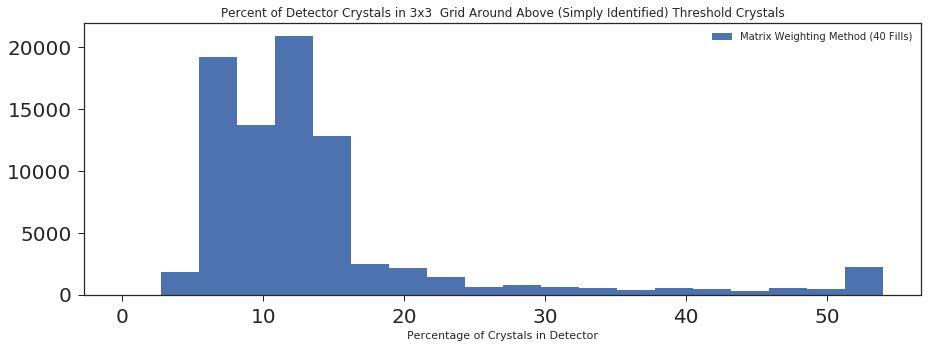

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
#plt.hist(simpleWeighted,bins=40,label='Simple Weighting',range=(0,100))
plt.hist(thresholdData['nCrystals3by3'],bins=20,label='Matrix Weighting Method (40 Fills)',range=(0,54))
plt.title("Percent of Detector Crystals in 3x3  Grid Around Above (Simply Identified) Threshold Crystals")
plt.xlabel("Percentage of Crystals in Detector")
plt.legend()
plt.show()

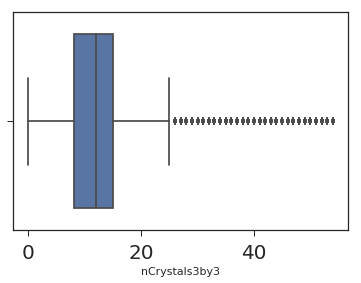

Mean: 13.864930986635507


In [12]:
sns.boxplot(thresholdData['nCrystals3by3'])
plt.show()
print("Mean:",np.mean(thresholdData['nCrystals3by3']))